In [122]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import librosa
import numpy as np
import IPython.display as ipd
from sklearn.preprocessing import StandardScaler
import joblib

In [123]:
dae = load_model('/mnt/c/Users/rafaj/Documents/datasets/audio-denoising-auto-encoder/autoencoder_model_test.keras')

In [124]:
dae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 148, 109, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 109, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 55, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 74, 55, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 28, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 66304)             0     

## Load a test audio file

In [125]:
file_path = "/mnt/c/Users/rafaj/Documents/datasets/audio-denoising-auto-encoder/data/processed_data/test/667626_18933d713e_2.wav"
y, sr = librosa.load(file_path)

In [126]:
sr, y[0].shape

(22050, ())

In [127]:
ipd.Audio(y, rate=sr)

## Preprocess the audio file

#### Add noise

In [128]:
def add_noise(feature, mean=0, std=0.05):
    noise = np.random.normal(mean, std, feature.shape)
    return feature + noise

In [129]:
y_noisy = add_noise(y)
ipd.Audio(y_noisy, rate=sr)

#### Extract mfcc and melspectrogram

In [130]:
sr=22050 
n_fft=2048
hop_length=512
n_mels=128
n_mfcc=20
fixed_length=55296
scal = joblib.load('/mnt/c/Users/rafaj/Documents/datasets/audio-denoising-auto-encoder/data/processed_data/weights/scaler.save')

In [131]:
def compute_mel_mfcc(y, sr, n_fft, hop_length, n_mels, n_mfcc, fixed_length, scal):
    y = librosa.util.fix_length(y, size=fixed_length)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length,
                                             n_mels=n_mels)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc)
    mfcc = scal.fit_transform(mfcc)
    return mel, mfcc


In [132]:
mel, mfcc = compute_mel_mfcc(y_noisy, sr, n_fft, hop_length, n_mels, n_mfcc, fixed_length, scal)

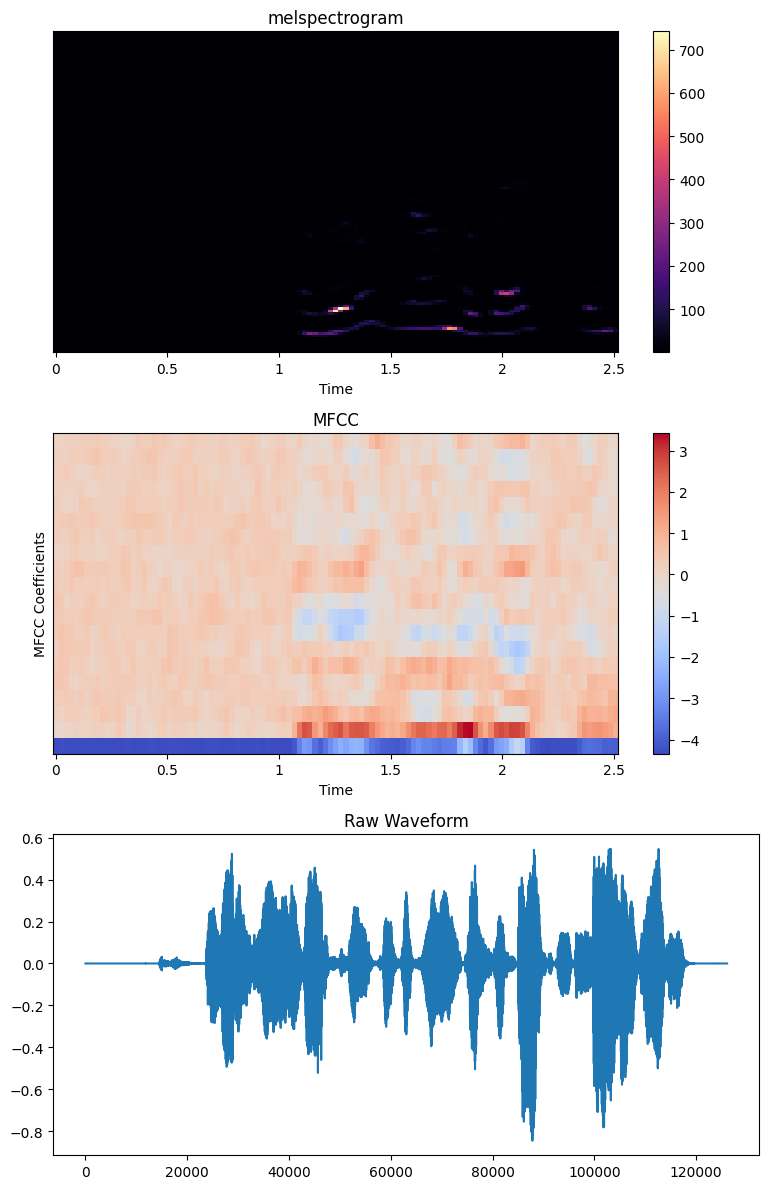

In [133]:
plt.figure(figsize=(15, 12))

# Raw waveform
plt.subplot(3, 2, 5)
plt.plot(y)
plt.title('Raw Waveform')

# melspectrogram
plt.subplot(3, 2, 1)
librosa.display.specshow(mel, x_axis='time')
plt.colorbar()
plt.title('melspectrogram')

# MFCC
plt.subplot(3, 2, 3)
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.ylabel('MFCC Coefficients')

plt.tight_layout()
plt.show()

### Hybrid representation

In [134]:
hybrid_representation = np.concatenate((mel, mfcc), axis=0)
hybrid_representation.shape

(148, 109)

In [135]:
test = np.expand_dims(hybrid_representation, axis=-1)
test.shape

(148, 109, 1)

### Train the model

In [136]:
denoised_audio = dae.predict(np.expand_dims(test, axis=0))

1/1 [==============================] - 0s 122ms/step


In [137]:
denoised_audio.shape

(1, 148, 109, 1)

In [138]:
denoised_audio = np.squeeze(denoised_audio, axis=0)  # Remove the first dimension
denoised_audio = np.squeeze(denoised_audio, axis=-1)  # Remove the last dimension
denoised_audio.shape

(148, 109)

### Revert transformation

In [139]:
def reconstruct_audio(hybrid_representation, sr, hop_length, n_mels):
    # Reshape hybrid representation to match original Mel spectrogram and MFCC shapes
    mel_reconstructed = hybrid_representation[:n_mels, :]
    mfcc_reconstructed = hybrid_representation[n_mels:, :]

    # Invert MFCC to obtain MFCC features
    mfcc_reconstructed = scal.inverse_transform(mfcc_reconstructed)

    # Invert Mel spectrogram to magnitude spectrogram
    mel_spectrogram_reconstructed = librosa.feature.inverse.mfcc_to_mel(mfcc_reconstructed, n_mels=n_mels)

    # Invert magnitude spectrogram to audio signal
    y_reconstructed_from_mfcc = librosa.feature.inverse.mel_to_audio(mel_spectrogram_reconstructed, sr=sr, hop_length=hop_length)
    
    y_reconstructed_from_mel = librosa.feature.inverse.mel_to_audio(mel_reconstructed, sr=sr, hop_length=hop_length)

    return y_reconstructed_from_mfcc, y_reconstructed_from_mel

In [140]:
y_reconstructed_from_mfcc, y_reconstructed_from_mel = reconstruct_audio(hybrid_representation, sr, hop_length, n_mels)

In [141]:
ipd.Audio(y_reconstructed_from_mfcc, rate=sr)

In [142]:
ipd.Audio(y_reconstructed_from_mel, rate=sr)

In [143]:
## clean audio
ipd.Audio(y, rate=sr)

## Demonstration

In [144]:
ipd.Audio(y_reconstructed_from_mel, rate=sr)

In [148]:
ipd.Audio(y_noisy, rate=sr)

In [146]:
ipd.Audio(y, rate=sr)